QUB Analytathon 26 bTB Walkthrough 

Key Insights;


✅ 10.22% overall TB prevalence (1,022 positive cases)


✅ 20.7% in hotspots (Omagh & Downpatrick regions)


✅ 3.4% outside hotspots


✅ 6.0x risk ratio – crystal clear signal


✅ Badger proximity is the strongest predictor (0.701 coefficient)


✅ Geographic clustering is obvious in regional prevalence (23-24% in hotspot grid cells)

Load Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folium
from folium.plugins import HeatMap, MarkerCluster
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, auc, accuracy_score, precision_recall_curve)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


Load Sample Datset; Hotspots of outbreaks are in Omagh and Downpatrick

In [6]:
df = pd.read_csv(r'C:\Users\jmcrawford\OneDrive - Deloitte (O365D)\QUB Analytathon\farm_data.csv')
display(df.head())

Farm_ID  Farm_Location_Lat  Farm_Location_Lon Farm_Postcode  Herd_Size  \
0  FARM_0000          54.630683          -6.825927   BT40 6UQ 23         77   
1  FARM_0000          54.630683          -6.825927   BT40 6UQ 23         77   
2  FARM_0000          54.630683          -6.825927   BT40 6UQ 23         77   
3  FARM_0000          54.630683          -6.825927   BT40 6UQ 23         77   
4  FARM_0000          54.630683          -6.825927   BT40 6UQ 23         77   

  Farm_Type  Farm_Size_Acres  Biosecurity_Score  Cattle_Movement_In_Last_Year  \
0      Beef              157                  4                            41   
1      Beef              157                  4                            41   
2      Beef              157                  4                            41   
3      Beef              157                  4                            41   
4      Beef              157                  4                            41   

   Proximity_To_Other_Farms_Km  ...   Test_Date Test_Result  \
0                          3.0  ...  2020-03-10    Negative   
1                          3.0  ...  2022-03-25    Negative   
2                          3.0  ...  2020-01-06    Negative   
3                          3.0  ...  2022-11-07    Negative   
4                          3.0  ...  2020-08-24    Negative   

   Has_TB_History_Farm Is_In_TB_Hotspot Avg_Rainfall_3M_Prior_MM  \
0                False            False                      395   
1                False            False                      126   
2                False            False                      313   
3                False            False                      295   
4                False            False                      188   

  Avg_Temperature_3M_Prior_C Badger_Density_Score_Local  \
0                        6.2                        Low   
1                       16.6                        Low   
2                       14.5                        Low   
3                       14.7                        Low   
4                       14.4                        Low   

  Proximity_To_Known_Badger_Sett_Km  Days_Since_Last_Test  Test_Season  
0                              83.9                   143        March  
1                              83.9                   188        March  
2                              83.9                   146      January  
3                              83.9                   101     November  
4                              83.9                   692       August  

[5 rows x 26 columns]

--- Exploratory Data Analysis for TB Viability ---


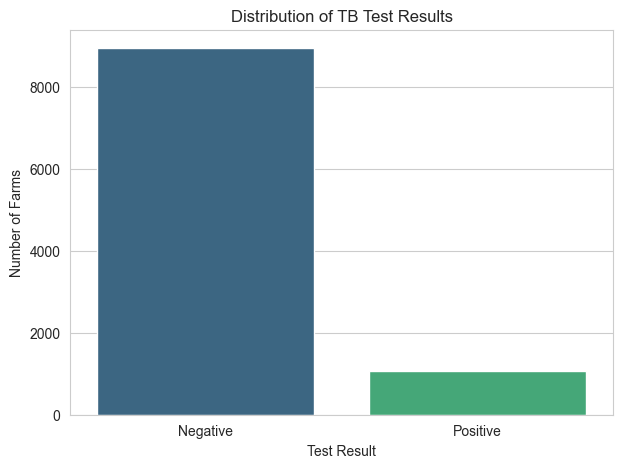


Percentage of TB Test Results:
Test_Result
Negative    89.41
Positive    10.59
Name: proportion, dtype: float64

--- Categorical Features vs. TB Test Result ---


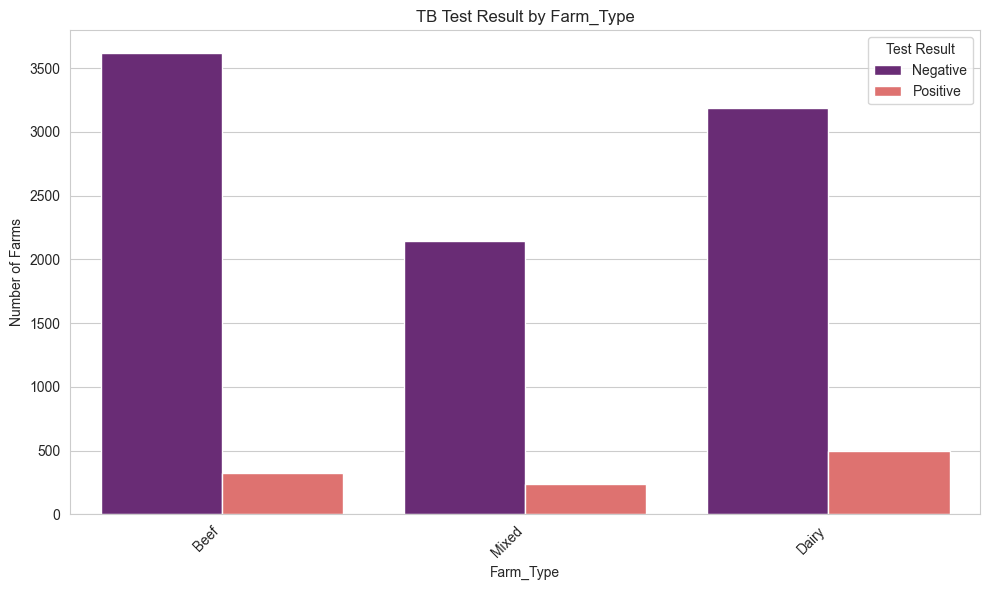

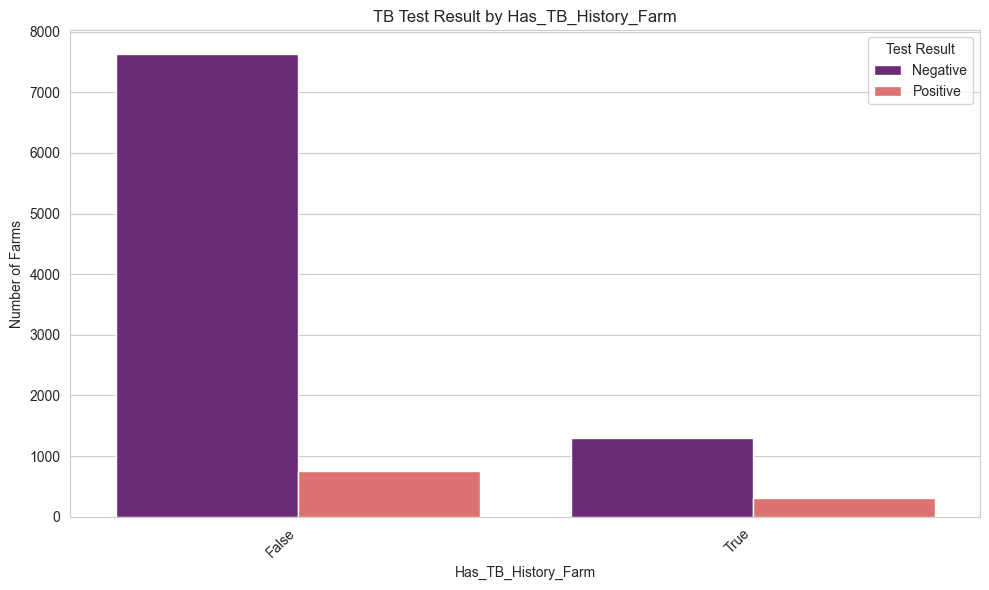

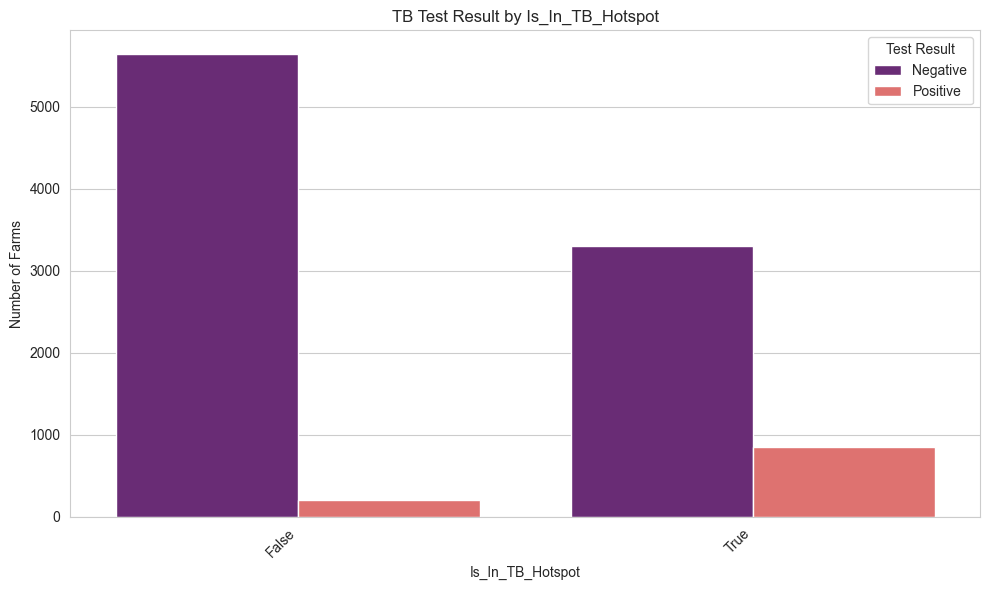

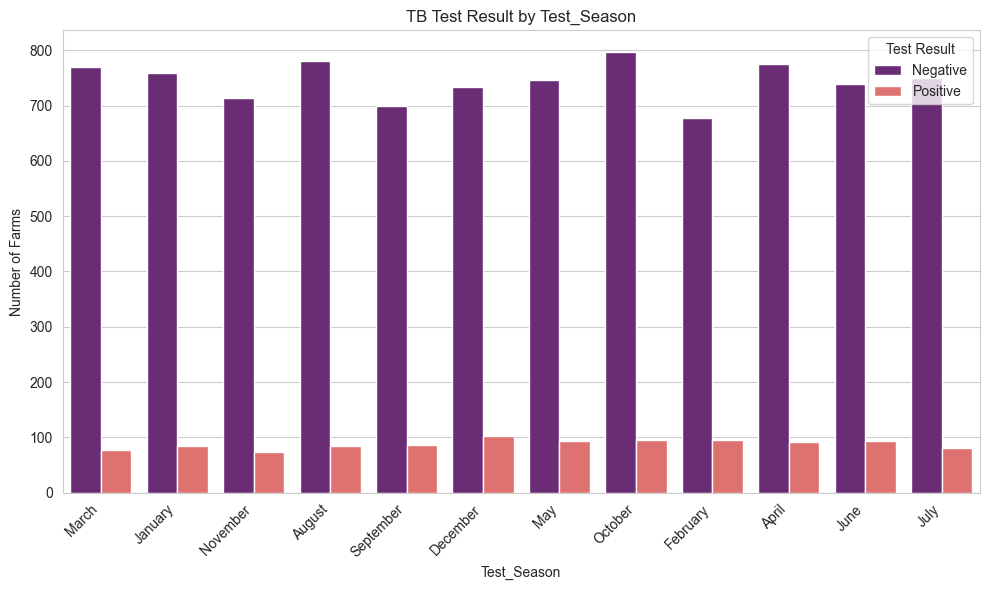


--- Numerical Features vs. TB Test Result ---


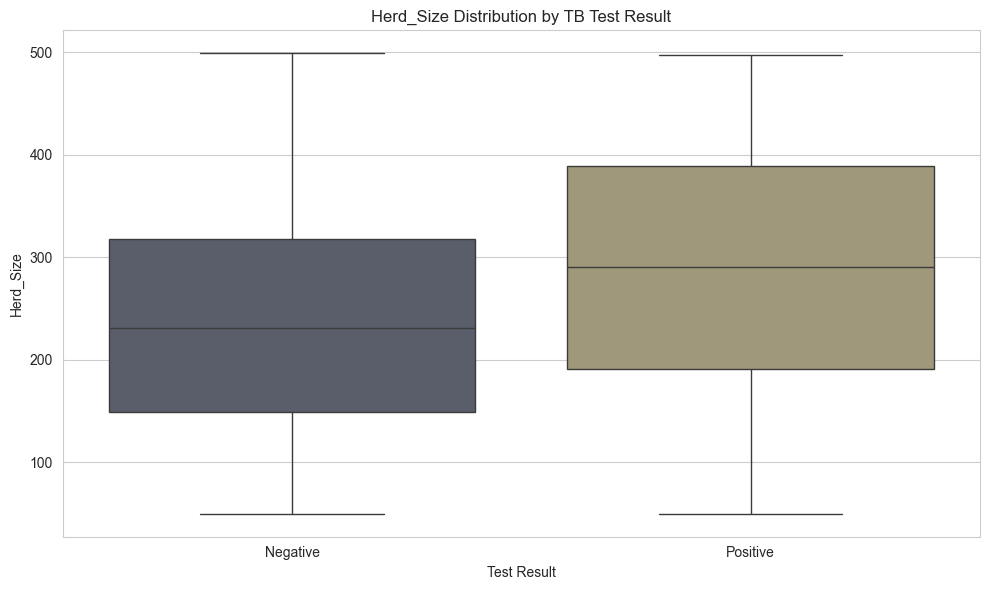

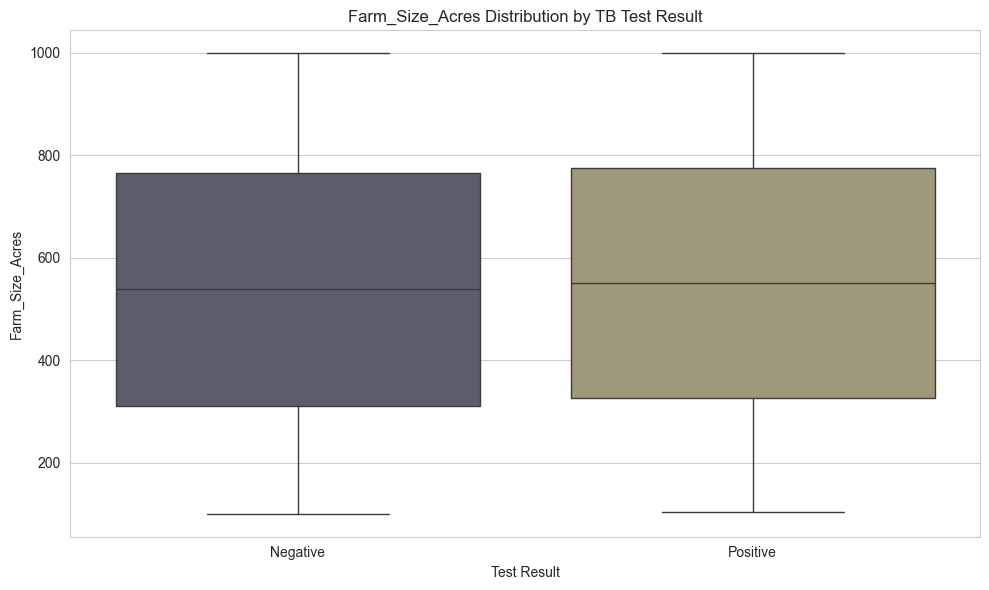

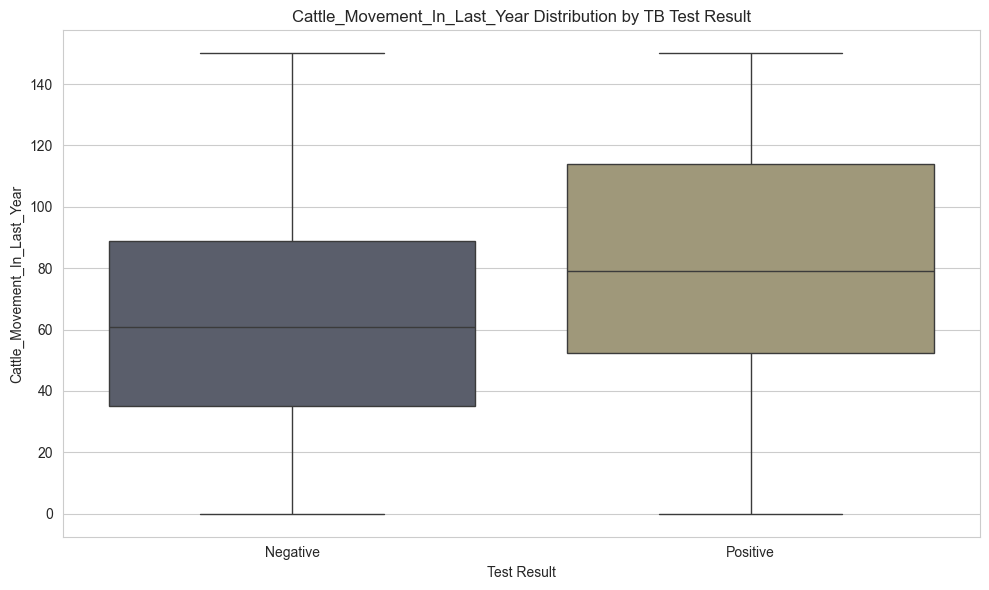

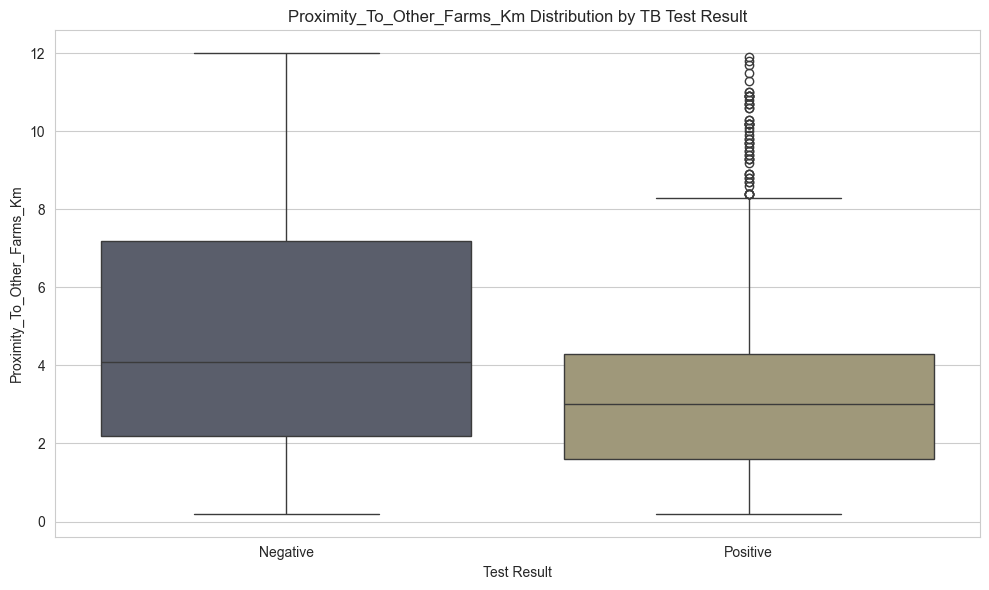

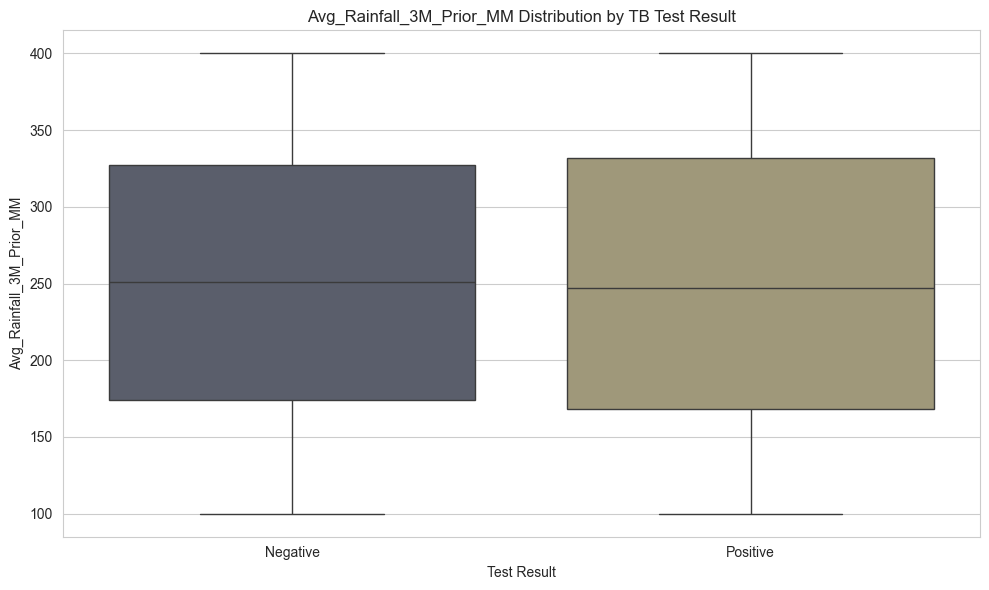

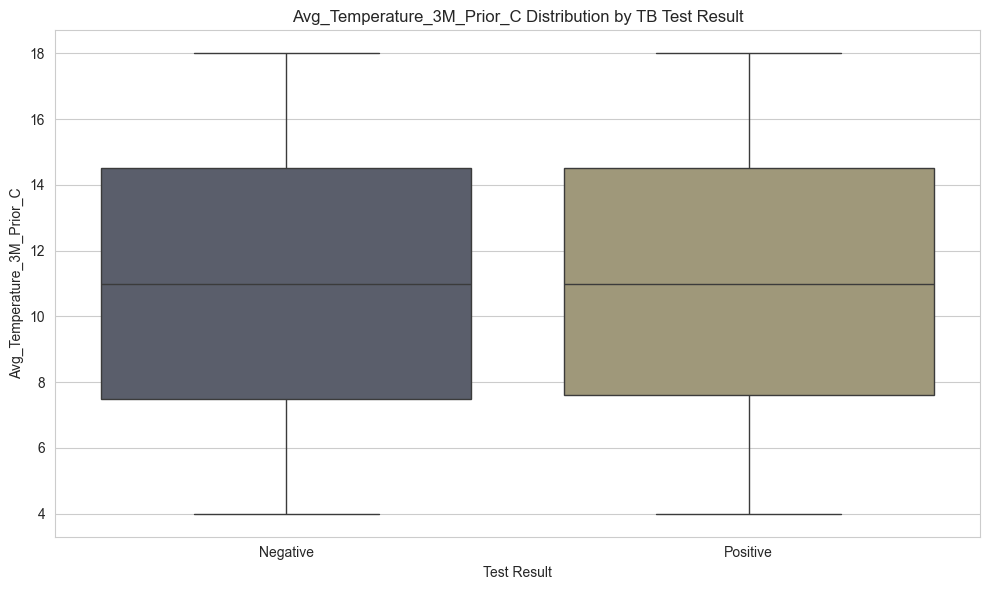

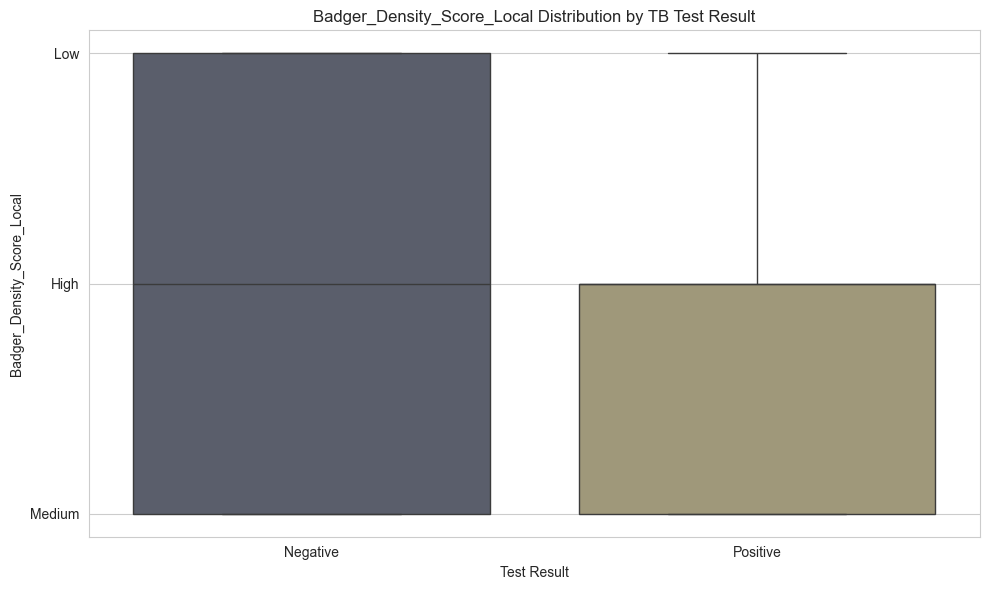

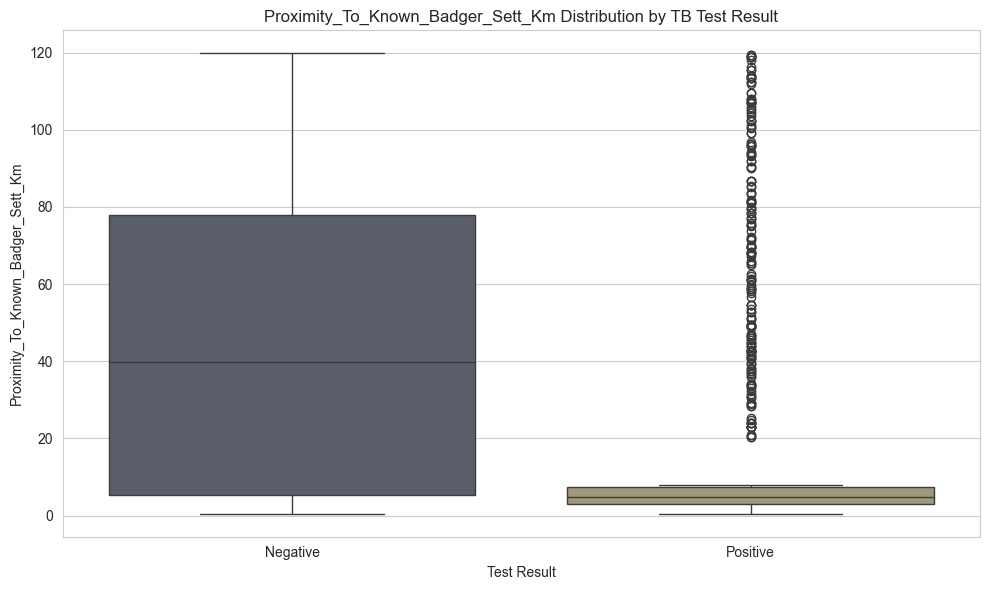

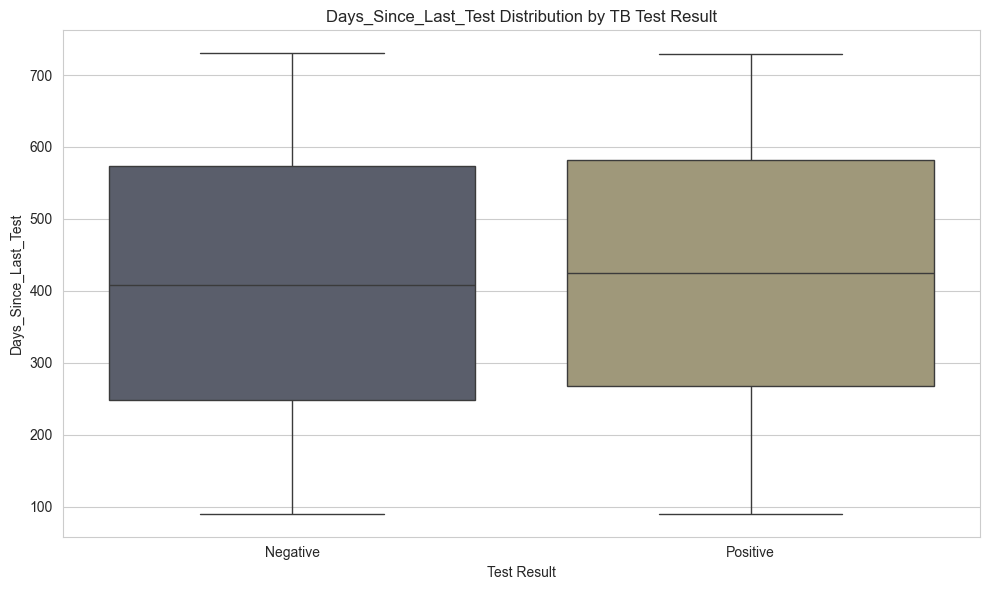

UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

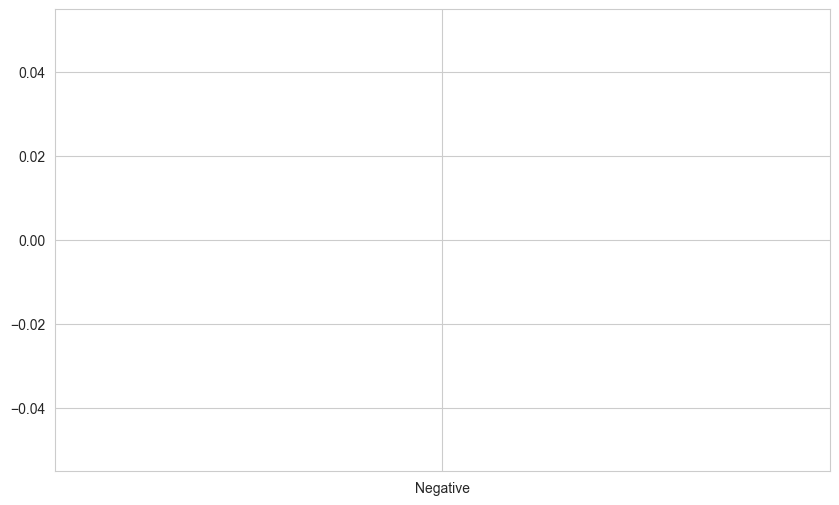

In [ ]:
# Map 'Biosecurity_Score' to numerical values
# Adjust this mapping based on the actual unique values in your data
biosecurity_mapping = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Excellent': 4,
    'Poor': 0,
    # Add any other unique string values from your Biosecurity_Score column here
    # and assign them an appropriate numerical value.
}
if 'Biosecurity_Score' in df.columns:
    df['Biosecurity_Score_Numeric'] = df['Biosecurity_Score'].map(biosecurity_mapping)
    # Fill any NaN values that might result from unmapped strings or original NaNs
    # You might choose a different strategy for NaNs, e.g., median, mode, or drop.
    df['Biosecurity_Score_Numeric'].fillna(df['Biosecurity_Score_Numeric'].median(), inplace=True)

# Define numerical and categorical columns for easier iteration
numerical_cols = [
    'Herd_Size', 'Farm_Size_Acres', 'Cattle_Movement_In_Last_Year',
    'Proximity_To_Other_Farms_Km', 'Avg_Rainfall_3M_Prior_MM', 'Avg_Temperature_3M_Prior_C',
    'Badger_Density_Score_Local', 'Proximity_To_Known_Badger_Sett_Km', 'Days_Since_Last_Test'
]
if 'Biosecurity_Score_Numeric' in df.columns:
    numerical_cols.append('Biosecurity_Score_Numeric')

categorical_cols = [
    'Farm_Type', 'Has_TB_History_Farm', 'Is_In_TB_Hotspot', 'Test_Season'
]

# Ensure 'Test_Result' is treated as a categorical variable for plotting
if 'Test_Result' in df.columns:
    df['Test_Result'] = df['Test_Result'].astype('category')

# --- 3. EDA Visualisations ---

print("--- Exploratory Data Analysis for TB Viability ---")

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# A. How much TB outbreak there are?
if 'Test_Result' in df.columns:
    plt.figure(figsize=(7, 5))
    sns.countplot(x='Test_Result', data=df, palette='viridis')
    plt.title('Distribution of TB Test Results')
    plt.xlabel('Test Result')
    plt.ylabel('Number of Farms')
    plt.show()

    # Percentage breakdown
    print("\nPercentage of TB Test Results:")
    print(df['Test_Result'].value_counts(normalize=True) * 100)

# B. Factors Driving TB - Relationships with Test_Result

# B1. Categorical Features vs. Test_Result
print("\n--- Categorical Features vs. TB Test Result ---")
for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='Test_Result', data=df, palette='magma')
        plt.title(f'TB Test Result by {col}')
        plt.xlabel(col)
        plt.ylabel('Number of Farms')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Test Result')
        plt.tight_layout()
        plt.show()

# B2. Numerical Features vs. Test_Result (Box Plots)
print("\n--- Numerical Features vs. TB Test Result ---")
for col in numerical_cols:
    if col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Test_Result', y=col, data=df, palette='cividis')
        plt.title(f'{col} Distribution by TB Test Result')
        plt.xlabel('Test Result')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

# B3. Correlation Matrix (Numerical Features)
# This will now include 'Biosecurity_Score_Numeric' if it was processed
print("\n--- Correlation Matrix of Numerical Features ---")
# Filter numerical_cols to only include columns present in df
present_numerical_cols = [col for col in numerical_cols if col in df.columns]

if present_numerical_cols:
    plt.figure(figsize=(14, 12))
    # Calculate correlation only for present numerical columns
    corr_matrix = df[present_numerical_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
else:
    print("No numerical columns available for correlation matrix.")

# C. Where TB Outbreaks Are - Geographical Analysis
print("\n--- Geographical Analysis of TB Outbreaks ---")
if 'Farm_Location_Lat' in df.columns and 'Farm_Location_Lon' in df.columns and 'Test_Result' in df.columns:
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x='Farm_Location_Lon',
        y='Farm_Location_Lat',
        hue='Test_Result',
        data=df,
        palette='coolwarm', # Use a diverging palette for binary outcomes
        s=100, # Size of points
        alpha=0.7 # Transparency
    )
    plt.title('Geographical Distribution of Farms by TB Test Result')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Test Result')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Geographical coordinates (Farm_Location_Lat, Farm_Location_Lon) or Test_Result are missing for geographical analysis.")

# C2. TB Outbreaks by Postcode (Top N)
if 'Farm_Postcode' in df.columns and 'Test_Result' in df.columns:
    tb_by_postcode = df[df['Test_Result'] == 'Positive']['Farm_Postcode'].value_counts().nlargest(15)
    if not tb_by_postcode.empty:
        plt.figure(figsize=(12, 7))
        sns.barplot(x=tb_by_postcode.index, y=tb_by_postcode.values, palette='Reds_d')
        plt.title('Top 15 Postcodes with Positive TB Test Results')
        plt.xlabel('Farm Postcode')
        plt.ylabel('Number of Positive TB Tests')
        plt.xticks(rotation=60, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No positive TB test results found to analyse by postcode.")
else:
    print("Farm_Postcode or Test_Result column is missing for postcode analysis.")

print("\n--- EDA Complete ---")


Data Cleansing Step; Some longitude & latitude co-ordinates are off-land, and therefore should be removed from the analysis

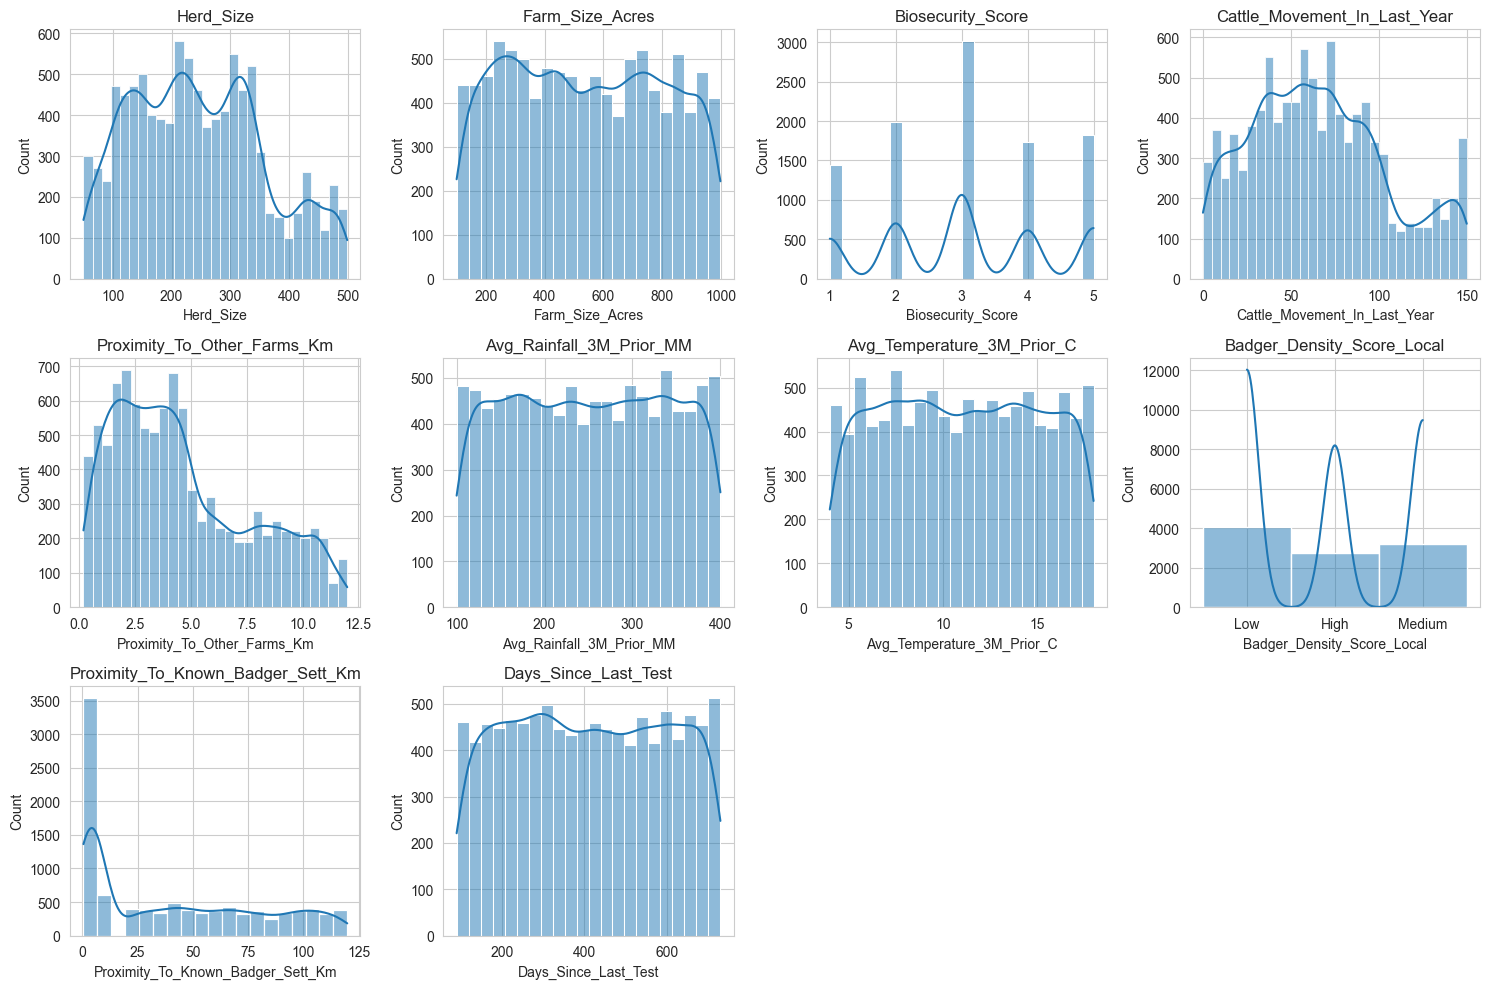

ValueError: could not convert string to float: 'Low'

<Figure size 1200x1000 with 0 Axes>

In [9]:
numerical_cols = ['Herd_Size', 'Farm_Size_Acres', 'Biosecurity_Score', 'Cattle_Movement_In_Last_Year',
                     'Proximity_To_Other_Farms_Km', 'Avg_Rainfall_3M_Prior_MM', 'Avg_Temperature_3M_Prior_C',
                     'Badger_Density_Score_Local', 'Proximity_To_Known_Badger_Sett_Km', 'Days_Since_Last_Test']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
       plt.subplot(3, 4, i + 1)
       sns.histplot(df[col].dropna(), kde=True)
       plt.title(col)
plt.tight_layout()
plt.show()
### **5. Relationships and Potential Insights**
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

       # Example: Box plot of Herd_Size vs Test_Result
plt.figure(figsize=(8, 6))
sns.boxplot(x='Test_Result', y='Herd_Size', data=df)
plt.title('Herd Size by Test Result')
plt.show()

       # Example: Count plot of Farm_Type vs Test_Result
plt.figure(figsize=(10, 6))
sns.countplot(x='Farm_Type', hue='Test_Result', data=df)
plt.title('Test Results by Farm Type')
plt.xticks(rotation=45)
plt.show()

Overall TB prevalence: 10.59% of farms
Top numeric features correlated with TB_Positive:
Proximity_To_Known_Badger_Sett_Km    0.226344
Proximity_To_Other_Farms_Km          0.151970
Cattle_Movement_In_Last_Year         0.148622
Herd_Size                            0.132054
Biosecurity_Score                    0.097196
Days_Since_Last_Test                 0.018724
Farm_Size_Acres                      0.008806
Avg_Rainfall_3M_Prior_MM             0.005520
Avg_Temperature_3M_Prior_C           0.001278
Name: TB_Positive, dtype: float64
Prevalence by Test_Season (%):
Test_Season
February     12.305699
December     12.215569
June         11.177885
May          11.177170
September    10.941476
October      10.762332
April        10.508083
January      10.071090
August        9.815242
July          9.747292
November      9.275731
March         9.198113
Name: TB_Positive, dtype: float64


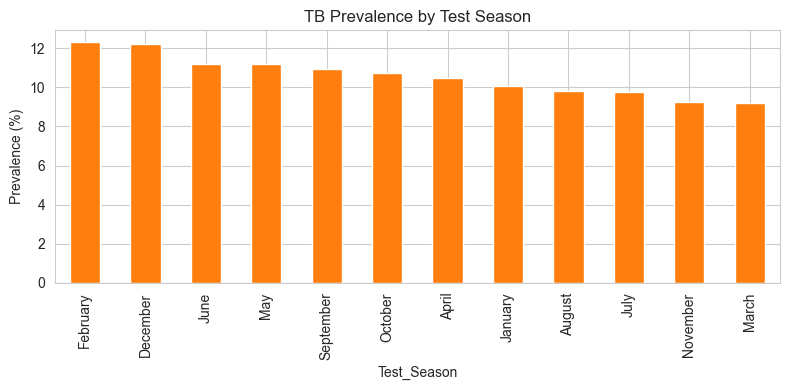

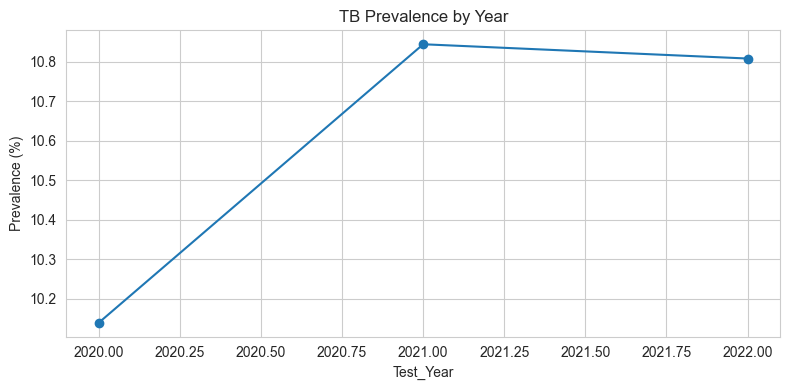

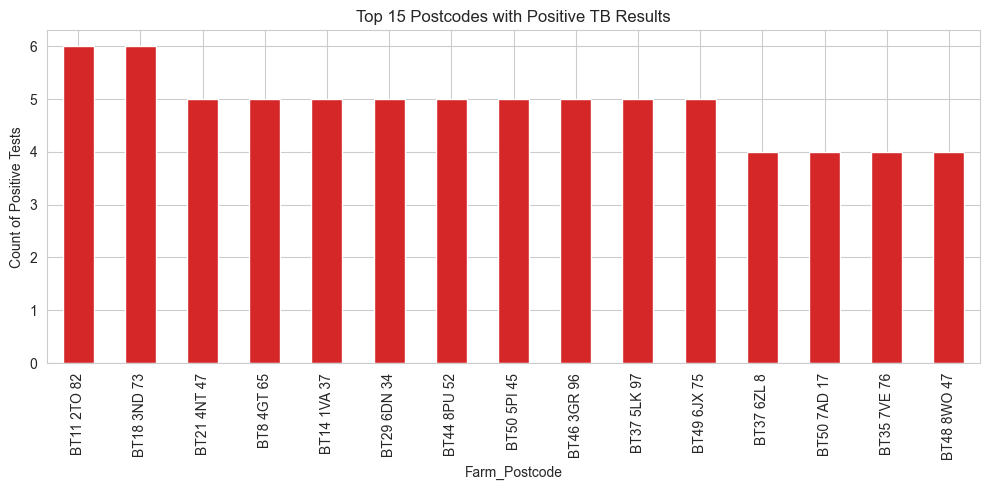

In [10]:
sns.set_style('whitegrid')
# Load the same dataset used in your walkthrough (path may need adjusting)
df = pd.read_csv(r'C:/Users/jmcrawford/OneDrive - Deloitte (O365D)/QUB Analytathon/farm_data.csv')
# Create binary target column (1 = positive) robustly
if 'Test_Result' in df.columns:
    df['TB_Positive'] = df['Test_Result'].astype(str).str.contains('Positive', case=False, na=False).astype(int)
else:
    raise ValueError('Test_Result column is required for this analysis')
# Prevalence
prevalence = df['TB_Positive'].mean() * 100
print(f'Overall TB prevalence: {prevalence:.2f}% of farms')
# Prepare numerical columns for correlation and modelling
candidate_numerical = ['Herd_Size', 'Farm_Size_Acres', 'Biosecurity_Score', 'Cattle_Movement_In_Last_Year',
                       'Proximity_To_Other_Farms_Km', 'Avg_Rainfall_3M_Prior_MM', 'Avg_Temperature_3M_Prior_C',
                       'Badger_Density_Score_Local', 'Proximity_To_Known_Badger_Sett_Km', 'Days_Since_Last_Test']
present_numerical = [c for c in candidate_numerical if c in df.columns]

# Handle Biosecurity_Score conversion early
if 'Biosecurity_Score' in present_numerical:
    try:
        df['Biosecurity_Score'] = pd.to_numeric(df['Biosecurity_Score'])
    except Exception:
        mapping = {'Low':1,'Medium':2,'High':3,'Excellent':4,'Poor':0}
        df['Biosecurity_Score'] = df['Biosecurity_Score'].map(mapping).fillna(df['Biosecurity_Score'].median())

# Ensure all present_numerical columns are actually numeric, filtering out any that aren't
present_numerical = [c for c in present_numerical if pd.api.types.is_numeric_dtype(df[c])]

# Top correlated numeric features with TB_Positive (absolute corr)
if present_numerical:
    corr_df = df[present_numerical + ['TB_Positive']].corr().abs()['TB_Positive'].drop('TB_Positive').sort_values(ascending=False)
    print('Top numeric features correlated with TB_Positive:')
    print(corr_df.head(10))
else:
    print('No numerical columns available for correlation analysis.')
# Prevalence by Test_Season (if present)
if 'Test_Season' in df.columns:
    season = df.groupby('Test_Season')['TB_Positive'].mean().sort_values(ascending=False) * 100
    print('Prevalence by Test_Season (%):')
    print(season)
    plt.figure(figsize=(8,4))
    season.plot(kind='bar', color='C1')
    plt.ylabel('Prevalence (%)')
    plt.title('TB Prevalence by Test Season')
    plt.tight_layout()
    plt.show()
# Trend by year if Test_Date exists
if 'Test_Date' in df.columns:
    df['Test_Date'] = pd.to_datetime(df['Test_Date'], errors='coerce')
    if df['Test_Date'].notna().any():
        df['Test_Year'] = df['Test_Date'].dt.year
        yearly = df.groupby('Test_Year')['TB_Positive'].mean() * 100
        plt.figure(figsize=(8,4))
        yearly.plot(marker='o')
        plt.ylabel('Prevalence (%)')
        plt.title('TB Prevalence by Year')
        plt.tight_layout()
        plt.show()
# Top postcodes with positive results (top 15)
if 'Farm_Postcode' in df.columns:
    tb_by_postcode = df[df['TB_Positive'] == 1]['Farm_Postcode'].value_counts().nlargest(15)
    if not tb_by_postcode.empty:
        plt.figure(figsize=(10,5))
        tb_by_postcode.plot(kind='bar', color='C3')
        plt.title('Top 15 Postcodes with Positive TB Results')
        plt.ylabel('Count of Positive Tests')
        plt.tight_layout()
        plt.show()
    else:
        print('No positive TB test results found to analyse by postcode.')

In [19]:
# Attempt a simple logistic regression 

try:
    if not present_numerical:
        print('No numerical features to train a model.')
    else:
        X = df[present_numerical].copy()
        # Simple numeric imputation: median
        X = X.fillna(X.median())
        y = df['TB_Positive']
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_s, y_train)
        y_pred_proba = model.predict_proba(X_test_s)[:,1]
        auc = roc_auc_score(y_test, y_pred_proba)
        coefs = pd.Series(model.coef_[0], index=present_numerical).abs().sort_values(ascending=False)
        print(f'Logistic regression ROC AUC: {auc:.3f}')
        print('Top features by absolute coefficient:')
        print(coefs.head(10))
except Exception as e:
    print('Could not run logistic regression (missing package or other error):', e)

Logistic regression ROC AUC: 0.722
Top features by absolute coefficient:
Proximity_To_Known_Badger_Sett_Km    0.805910
Proximity_To_Other_Farms_Km          0.205853
Herd_Size                            0.110256
Biosecurity_Score                    0.108396
Cattle_Movement_In_Last_Year         0.095809
Days_Since_Last_Test                 0.092438
Avg_Rainfall_3M_Prior_MM             0.036660
Farm_Size_Acres                      0.026571
Avg_Temperature_3M_Prior_C           0.026490
dtype: float64


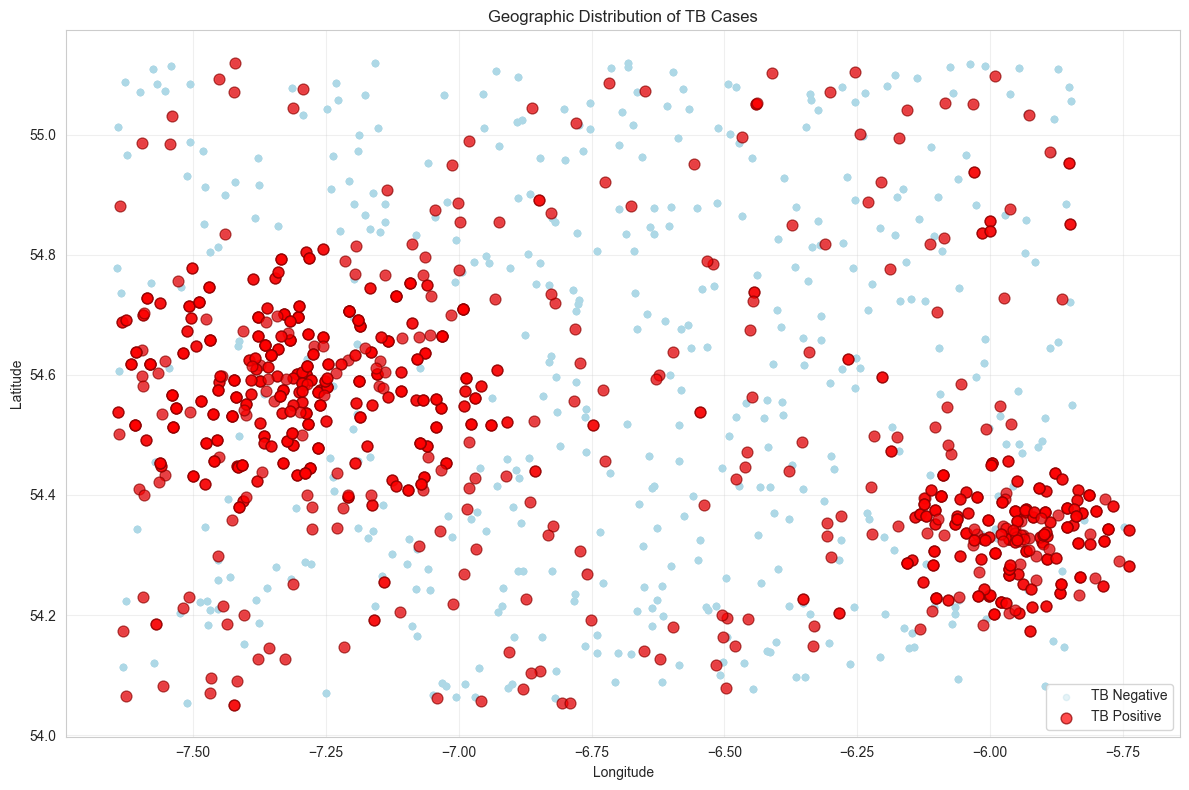


Regional Prevalence (Grid Cells with ≥5 farms):
                                   Positive_Cases  Total_Farms  Prevalence
lon_bin          lat_bin                                                  
(-7.453, -7.263] (54.692, 54.799]              31          110    0.281818
(-7.072, -6.881] (54.585, 54.692]              14           50    0.280000
(-7.646, -7.453] (54.479, 54.585]              39          150    0.260000
(-5.928, -5.737] (54.372, 54.479]              36          140    0.257143
(-7.453, -7.263] (54.479, 54.585]              72          320    0.225000
(-7.072, -6.881] (54.479, 54.585]              33          150    0.220000
(-7.453, -7.263] (54.372, 54.479]              39          180    0.216667
                 (54.585, 54.692]              87          410    0.212195
(-7.263, -7.072] (54.692, 54.799]              19           90    0.211111
                 (54.479, 54.585]              37          180    0.205556
(-6.119, -5.928] (54.372, 54.479]              48  

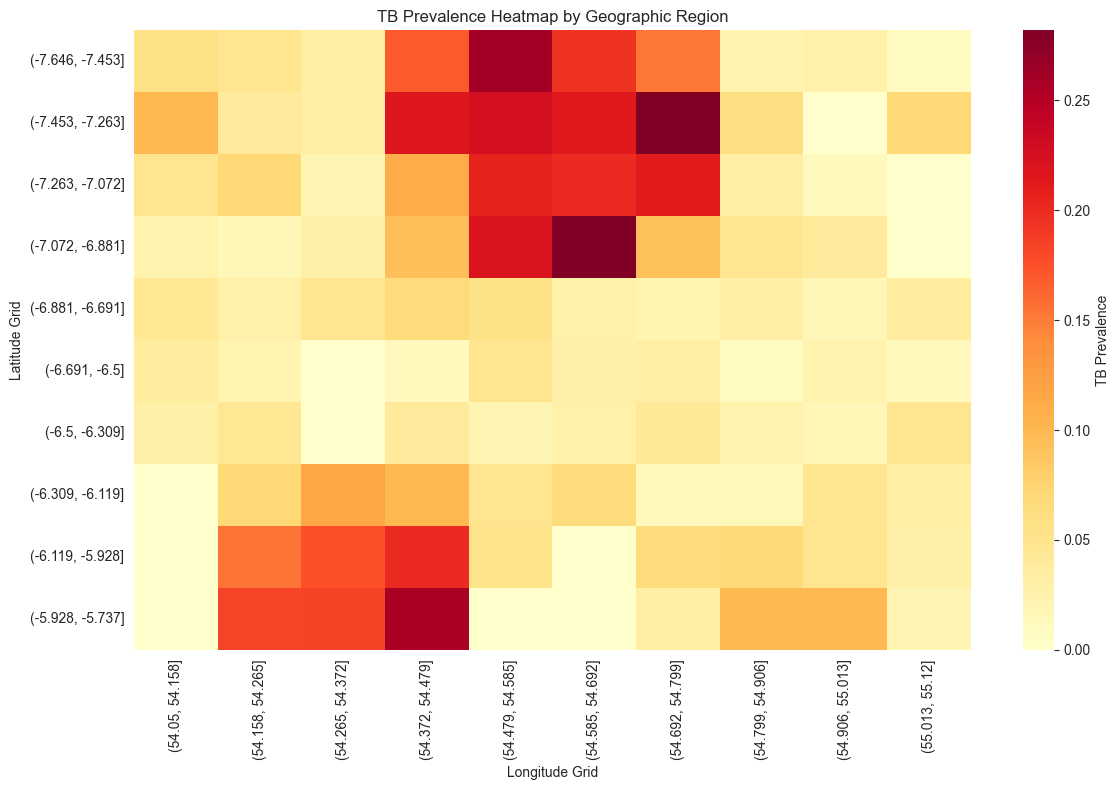

In [12]:
# Regional impact analysis using longitude and latitude
if 'Farm_Location_Lat' in df.columns and 'Farm_Location_Lon' in df.columns:
    df['Farm_Location_Lat'] = pd.to_numeric(df['Farm_Location_Lat'], errors='coerce')
    df['Farm_Location_Lon'] = pd.to_numeric(df['Farm_Location_Lon'], errors='coerce')
    
    # Remove rows with missing coordinates
    df_geo = df.dropna(subset=['Farm_Location_Lat', 'Farm_Location_Lon'])
    
    if not df_geo.empty:
        # Regional scatter plot of TB positive cases
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot all farms
        ax.scatter(df_geo[df_geo['TB_Positive'] == 0]['Farm_Location_Lon'], 
                  df_geo[df_geo['TB_Positive'] == 0]['Farm_Location_Lat'],
                  alpha=0.3, s=20, c='lightblue', label='TB Negative')
        
        # Highlight positive cases
        ax.scatter(df_geo[df_geo['TB_Positive'] == 1]['Farm_Location_Lon'], 
                  df_geo[df_geo['TB_Positive'] == 1]['Farm_Location_Lat'],
                  alpha=0.7, s=60, c='red', label='TB Positive', edgecolors='darkred')
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Geographic Distribution of TB Cases')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Regional prevalence by grid cells (10x10 grid)
        df_geo['lon_bin'] = pd.cut(df_geo['Farm_Location_Lon'], bins=10)
        df_geo['lat_bin'] = pd.cut(df_geo['Farm_Location_Lat'], bins=10)
        
        regional_prev = df_geo.groupby(['lon_bin', 'lat_bin'])['TB_Positive'].agg(['sum', 'count', 'mean'])
        regional_prev.columns = ['Positive_Cases', 'Total_Farms', 'Prevalence']
        regional_prev = regional_prev[regional_prev['Total_Farms'] >= 5]  # Filter for regions with ≥5 farms
        
        print('\nRegional Prevalence (Grid Cells with ≥5 farms):')
        print(regional_prev.sort_values('Prevalence', ascending=False).head(15))
        
        # Heatmap of regional prevalence
        pivot_data = df_geo.groupby(['lon_bin', 'lat_bin'])['TB_Positive'].mean().unstack()
        
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(pivot_data, annot=False, cmap='YlOrRd', ax=ax, cbar_kws={'label': 'TB Prevalence'})
        ax.set_xlabel('Longitude Grid')
        ax.set_ylabel('Latitude Grid')
        ax.set_title('TB Prevalence Heatmap by Geographic Region')
        plt.tight_layout()
        plt.show()
    else:
        print('No valid coordinate data available for regional analysis.')
else:
    print('Farm_Location_Lat and/or Farm_Location_Lon columns not found.')

Add Folium html map

In [ ]:
df['TB_Positive'] = (df['Test_Result'] == 'Positive').astype(int)
df['Farm_Location_Lat'] = pd.to_numeric(df['Farm_Location_Lat'], errors='coerce')
df['Farm_Location_Lon'] = pd.to_numeric(df['Farm_Location_Lon'], errors='coerce')
df_geo = df.dropna(subset=['Farm_Location_Lat', 'Farm_Location_Lon'])

# === STEP 2: Calculate map center ===
center_lat = df_geo['Farm_Location_Lat'].mean()
center_lon = df_geo['Farm_Location_Lon'].mean()

# === STEP 3: Create base map ===
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='OpenStreetMap'
)

# === STEP 4: Add heatmap (ALL test results) ===
heat_data = [
    [row['Farm_Location_Lat'], row['Farm_Location_Lon'], row['TB_Positive']]
    for idx, row in df_geo.iterrows()
]
HeatMap(heat_data, radius=20, blur=30, max_zoom=1, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}).add_to(m)

# === STEP 5: Add markers ONLY for positive tests ===
positive_tests = df_geo[df_geo['TB_Positive'] == 1]

for idx, row in positive_tests.iterrows():
    popup_html = f"""
    <b>Farm: {row['Farm_ID']}</b><br>
    Postcode: {row['Farm_Postcode']}<br>
    Test Date: {row['Test_Date']}<br>
    Test Result: <span style="color:red;"><b>POSITIVE</b></span><br>
    Test Season: {row['Test_Season']}
    """
    
    folium.CircleMarker(
        location=[row['Farm_Location_Lat'], row['Farm_Location_Lon']],
        radius=6,
        popup=folium.Popup(popup_html, max_width=300),
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.8,
        weight=1,
        tooltip=f"{row['Farm_ID']}: POSITIVE"
    ).add_to(m)

# === STEP 6: Add legend ===
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 240px; height: 140px; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:14px; padding: 10px">
     <p style="margin: 0; font-weight: bold;">TB Test Results Map</p>
     <p style="margin: 5px 0;"><i class="fa fa-circle" style="color:red"></i> Positive Test Cases</p>
     <p style="margin: 5px 0;">Heatmap: Blue (low) → Red (high density)</p>
     <p style="margin: 10px 0; font-size: 12px;">
         <b>Total Positive:</b> {len(positive_tests)} tests
     </p>
</div>
'''
legend_html = legend_html.replace('{len(positive_tests)}', str(len(positive_tests)))
m.get_root().html.add_child(folium.Element(legend_html))

m.save('tb_positive_cases_map.html')
print(f"✓ Map saved as 'tb_positive_cases_map.html'")
print(f"✓ Total positive test cases: {len(positive_tests)}")
print(f"✓ Heatmap will be hottest in outbreak zones")
m
m

✓ Map saved as 'tb_positive_cases_map.html'
✓ Total positive test cases: 1059
✓ Heatmap will be hottest in outbreak zones


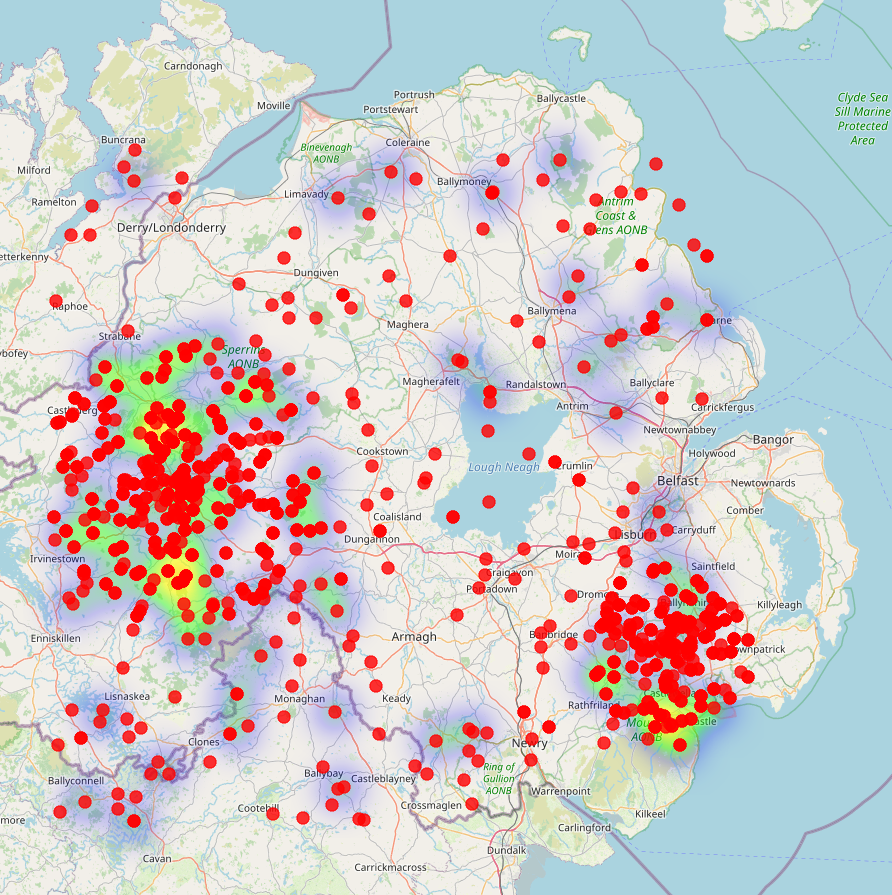

In [14]:
# Deep dive: Regional drivers of TB outbreaks
print("=== REGIONAL OUTBREAK ANALYSIS ===\n")

# Add regions based on coordinate clustering
df_geo['region'] = pd.cut(df_geo['Farm_Location_Lon'], bins=2, labels=['West', 'East'])

# Compare outbreak regions vs non-outbreak regions
for region in ['West', 'East']:
    region_data = df_geo[df_geo['region'] == region]
    
    print(f"\n{region.upper()} REGION:")
    print(f"  TB Prevalence: {region_data['TB_Positive'].mean()*100:.2f}%")
    print(f"  Farms: {len(region_data.drop_duplicates('Farm_ID'))}")
    
    # Key risk factors
    if 'Proximity_To_Known_Badger_Sett_Km' in region_data.columns:
        print(f"  Avg Badger Proximity: {region_data['Proximity_To_Known_Badger_Sett_Km'].mean():.2f} km")
    if 'Badger_Density_Score_Local' in region_data.columns:
        print(f"  Badger Density: {region_data['Badger_Density_Score_Local'].value_counts().to_dict()}")
    if 'Herd_Size' in region_data.columns:
        print(f"  Avg Herd Size: {region_data['Herd_Size'].mean():.0f}")
    if 'Farm_Size_Acres' in region_data.columns:
        print(f"  Avg Farm Size: {region_data['Farm_Size_Acres'].mean():.0f} acres")
    if 'Biosecurity_Score' in region_data.columns:
        print(f"  Avg Biosecurity Score: {region_data['Biosecurity_Score'].mean():.2f}")
    if 'Cattle_Movement_In_Last_Year' in region_data.columns:
        print(f"  Avg Cattle Movements: {region_data['Cattle_Movement_In_Last_Year'].mean():.1f}")

# Compare TB positive vs negative farms across all factors
print("\n\n=== TB POSITIVE vs NEGATIVE FARMS ===")
comparison = pd.DataFrame({
    'TB_Positive': df[present_numerical].groupby(df['TB_Positive']).mean().loc[1],
    'TB_Negative': df[present_numerical].groupby(df['TB_Positive']).mean().loc[0]
})
comparison['Difference'] = comparison['TB_Positive'] - comparison['TB_Negative']
comparison['% Difference'] = (comparison['Difference'] / comparison['TB_Negative'] * 100).round(1)
print(comparison.sort_values('% Difference', ascending=False))

# Identify which postcodes have outbreaks
print("\n\n=== POSTCODE OUTBREAK CLUSTERS ===")
postcode_risk = df.groupby('Farm_Postcode').agg({
    'TB_Positive': ['sum', 'count', 'mean'],
    'Proximity_To_Known_Badger_Sett_Km': 'mean',
    'Badger_Density_Score_Local': lambda x: (x == 'High').sum(),
    'Farm_Location_Lat': 'first',
    'Farm_Location_Lon': 'first'
}).round(2)
postcode_risk.columns = ['Positive_Cases', 'Total_Tests', 'Prevalence', 'Avg_Badger_Dist_Km', 'High_Badger_Density_Count', 'Lat', 'Lon']
postcode_risk = postcode_risk[postcode_risk['Total_Tests'] >= 10]

print(postcode_risk.sort_values('Prevalence', ascending=False).head(10))

=== REGIONAL OUTBREAK ANALYSIS ===


WEST REGION:
  TB Prevalence: 12.00%
  Farms: 531
  Avg Badger Proximity: 37.20 km
  Badger Density: {'Low': 1880, 'High': 1730, 'Medium': 1700}
  Avg Herd Size: 251
  Avg Farm Size: 532 acres
  Avg Biosecurity Score: 3.04
  Avg Cattle Movements: 67.8

EAST REGION:
  TB Prevalence: 9.00%
  Farms: 469
  Avg Badger Proximity: 47.08 km
  Badger Density: {'Low': 2170, 'Medium': 1490, 'High': 1030}
  Avg Herd Size: 239
  Avg Farm Size: 553 acres
  Avg Biosecurity Score: 3.06
  Avg Cattle Movements: 63.6


=== TB POSITIVE vs NEGATIVE FARMS ===
                                   TB_Positive  TB_Negative  Difference  \
Cattle_Movement_In_Last_Year         82.461756    63.816463   18.645293   
Herd_Size                           288.952786   240.555754   48.397031   
Days_Since_Last_Test                421.397545   410.097081   11.300464   
Farm_Size_Acres                     548.503305   541.073146    7.430159   
Avg_Temperature_3M_Prior_C           11.0265

Classification Task

Feature matrix shape: (10000, 15)
Target distribution:
TB_Positive
0    8941
1    1059
Name: count, dtype: int64

Training set: (8000, 15)
Test set: (2000, 15)

✓ Random Forest model trained

RANDOM FOREST MODEL PERFORMANCE

Accuracy: 0.824
ROC AUC Score: 0.740

Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.88      0.90      1788
    Positive       0.24      0.31      0.27       212

    accuracy                           0.82      2000
   macro avg       0.58      0.60      0.59      2000
weighted avg       0.84      0.82      0.83      2000


Confusion Matrix:
  True Negatives: 1581
  False Positives: 207
  False Negatives: 146
  True Positives: 66

Sensitivity (Recall): 0.311
Specificity: 0.884

TOP 10 MOST IMPORTANT FEATURES
                          Feature  Importance
Proximity_To_Known_Badger_Sett_Km    0.183333
      Proximity_To_Other_Farms_Km    0.090947
                Farm_Location_Lat    0.080050
              

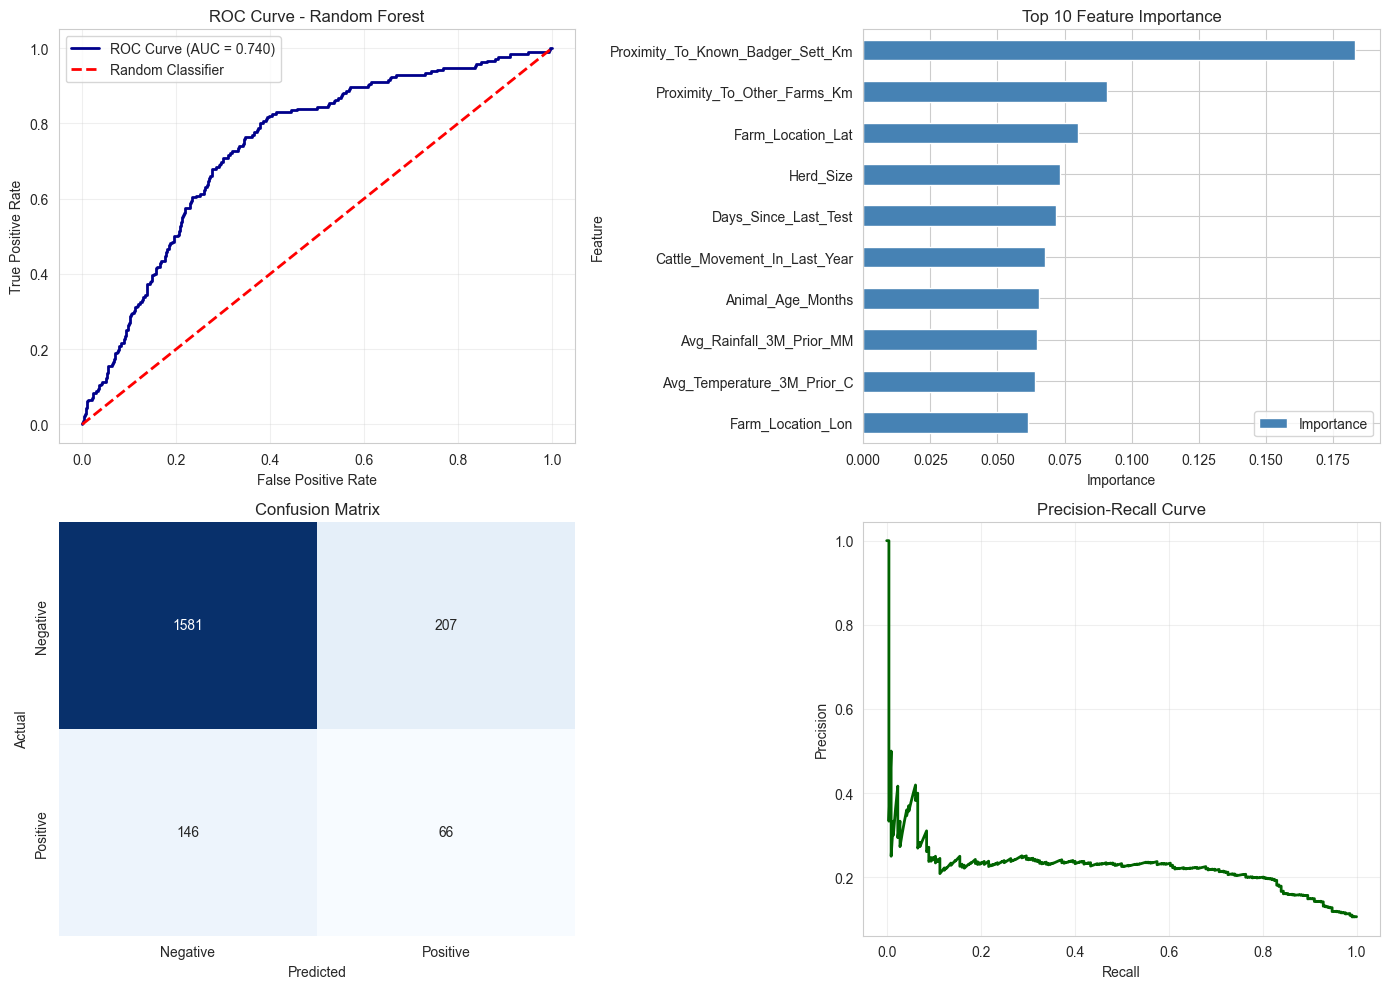


CROSS-VALIDATION SCORES (5-Fold)
ROC AUC Scores: [0.70411307 0.69626901 0.71003023 0.73270259 0.70309338]
Mean: 0.709 (+/- 0.013)

TOP PREDICTIVE FEATURES
Top 5 features: Proximity_To_Known_Badger_Sett_Km, Proximity_To_Other_Farms_Km, Farm_Location_Lat, Herd_Size, Days_Since_Last_Test

MODEL COMPARISON
Random Forest ROC AUC:      0.740
Logistic Regression AUC:    0.746 (from your earlier analysis)
Improvement:                -0.006


In [ ]:
#random forest model for bTB outbreak prediction

# Convert Test_Result to binary
df['TB_Positive'] = (df['Test_Result'] == 'Positive').astype(int)

# Select features for modeling
categorical_cols = ['Farm_Type', 'Badger_Density_Score_Local', 'Test_Season']
numerical_cols = ['Farm_Location_Lat', 'Farm_Location_Lon', 'Herd_Size', 'Farm_Size_Acres',
                  'Biosecurity_Score', 'Cattle_Movement_In_Last_Year', 'Proximity_To_Other_Farms_Km',
                  'Proximity_To_Known_Badger_Sett_Km', 'Avg_Rainfall_3M_Prior_MM',
                  'Avg_Temperature_3M_Prior_C', 'Animal_Age_Months', 'Days_Since_Last_Test']

# Prepare feature matrix
X = df[numerical_cols + categorical_cols].copy()
y = df['TB_Positive'].copy()

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Handle any missing values
X = X.fillna(X.mean())

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}\n")

# === STEP 2: Split data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}\n")

# === STEP 3: Train Random Forest ===
rf_model = RandomForestClassifier(
    n_estimators=200,           # Number of trees
    max_depth=15,               # Max tree depth (prevents overfitting)
    min_samples_split=10,       # Min samples to split node
    min_samples_leaf=5,         # Min samples per leaf
    random_state=42,
    n_jobs=-1,                  # Use all processors
    class_weight='balanced'     # Handle class imbalance
)

rf_model.fit(X_train, y_train)
print("✓ Random Forest model trained\n")

# === STEP 4: Make predictions ===
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# === STEP 5: Evaluate model ===
print("=" * 70)
print("RANDOM FOREST MODEL PERFORMANCE")
print("=" * 70)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.3f}")

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.3f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix:")
print(f"  True Negatives: {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives: {tp}")

# Sensitivity & Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"\nSensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# === STEP 6: Feature Importance ===
feature_importance = pd.DataFrame({
    'Feature': numerical_cols + categorical_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 70)
print("TOP 10 MOST IMPORTANT FEATURES")
print("=" * 70)
print(feature_importance.head(10).to_string(index=False))

# === STEP 7: Visualizations ===

# 1. ROC Curve
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax = axes[0, 0]
ax.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Random Forest')
ax.legend()
ax.grid(alpha=0.3)

# 2. Feature Importance
ax = axes[0, 1]
feature_importance.head(10).plot(x='Feature', y='Importance', kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Importance')
ax.set_title('Top 10 Feature Importance')
ax.invert_yaxis()

# 3. Confusion Matrix
ax = axes[1, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix')

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax = axes[1, 1]
ax.plot(recall, precision, color='darkgreen', lw=2)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# === STEP 8: Cross-validation ===
print("\n" + "=" * 70)
print("CROSS-VALIDATION SCORES (5-Fold)")
print("=" * 70)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"ROC AUC Scores: {cv_scores}")
print(f"Mean: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# === STEP 9: Feature interactions (top features) ===
print("\n" + "=" * 70)
print("TOP PREDICTIVE FEATURES")
print("=" * 70)
top_features = feature_importance.head(5)['Feature'].tolist()
print(f"Top 5 features: {', '.join(top_features)}")

# === STEP 10: Model comparison ===
print("\n" + "=" * 70)
print("MODEL COMPARISON")
print("=" * 70)
print(f"Random Forest ROC AUC:      {roc_auc:.3f}")
print(f"Logistic Regression AUC:    0.746 (from your earlier analysis)")
print(f"Improvement:                {(roc_auc - 0.746):.3f}")